In [8]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import os
import sys

# Get the absolute path to the root directory of the project
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))

print(f"Root directory: {ROOT_DIR}")

# Add root to sys.path so "src" becomes importable
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

from utils.evaluation import calculate_mae, calculate_mda

Root directory: /home/pratyush/Desktop/INLP/project/AmbiguityAssault/src


In [5]:
# Load the Yahoo data
yahoo_data = pd.read_csv('../../dataset/results/AAPL_yahoo_data.csv')

# Preprocess the data
yahoo_data['Date'] = pd.to_datetime(yahoo_data['Date'].str.split(' ').str[0]) # Extract date part and convert
yahoo_data.set_index('Date', inplace=True)
data = yahoo_data['Adj Close'].dropna() # Use Adjusted Close price and drop any potential NaNs

# Explicitly set frequency
data = data.asfreq('B')  # Business day frequency

# Split data into training and testing sets (e.g., last 30 days for testing)
train_data = data[:-10]
test_data = data[-10:]

# Implement ARIMA model
# For baseline, let's use a simple order (5,1,0). Parameter tuning is not the focus here for baseline.
order = (5, 1, 1) # (p, d, q)
model = ARIMA(train_data, order=order)
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.forecast(steps=len(test_data))

predictions_series = pd.Series(predictions, index=test_data.index)

# --- Evaluation Metrics as per proposal ---

# def calculate_mda(actual, predicted):
#     """
#     Calculates Mean Directional Accuracy (MDA).
#     """
#     actual_returns = actual.pct_change().dropna()
#     predicted_returns = predicted.pct_change().dropna()

#     # Align indices in case of any mismatch due to pct_change
#     common_index = actual_returns.index.intersection(predicted_returns.index)
#     actual_returns = actual_returns.loc[common_index]
#     predicted_returns = predicted_returns.loc[common_index]

#     correct_direction = np.sign(actual_returns) == np.sign(predicted_returns)
#     mda = np.mean(correct_direction)
#     return mda

def calculate_sharpe_ratio(predicted_returns, risk_free_rate=0.0, trading_days=252):
    """
    Calculates annualized Sharpe Ratio.
    Assuming predicted_returns are daily returns.
    """
    excess_returns = predicted_returns - (risk_free_rate / trading_days)
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)
    annualized_sharpe_ratio = sharpe_ratio * np.sqrt(trading_days)
    return annualized_sharpe_ratio

def calculate_pearson_correlation(actual, predicted):
    """
    Calculates Pearson Correlation between actual and predicted returns.
    """
    actual_returns = actual.pct_change().dropna()
    predicted_returns = predicted.pct_change().dropna()

    # Align indices
    common_index = actual_returns.index.intersection(predicted_returns.index)
    actual_returns = actual_returns.loc[common_index]
    predicted_returns = predicted_returns.loc[common_index]

    correlation = np.corrcoef(actual_returns, predicted_returns)[0, 1]
    return correlation


# Calculate evaluation metrics
mda = calculate_mda(test_data, predictions_series)

# Calculate predicted returns for Sharpe Ratio
predicted_returns_for_sharpe = predictions_series.pct_change().dropna() # Returns based on predicted prices
sharpe_ratio = calculate_sharpe_ratio(predicted_returns_for_sharpe)

# print(test_data)
# print(predictions_series)

pearson_correlation = calculate_pearson_correlation(test_data, predictions_series)


# --- Additional common metrics (MAE, RMSE) for completeness ---
mae = mean_absolute_error(test_data, predictions_series)
rmse = sqrt(mean_squared_error(test_data, predictions_series))


# Print results
print("ARIMA Baseline Model Evaluation Metrics:")
print(f"  Mean Directional Accuracy (MDA): {mda:.4f}")
print(f"  Annualized Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"  Pearson Correlation (of returns): {pearson_correlation:.4f}")
print("\nAdditional Metrics (for reference):")
print(f"  Mean Absolute Error (MAE): {mae:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")

ARIMA Baseline Model Evaluation Metrics:
  Mean Directional Accuracy (MDA): 1.0000
  Annualized Sharpe Ratio: -0.5260
  Pearson Correlation (of returns): 0.2135

Additional Metrics (for reference):
  Mean Absolute Error (MAE): 5.7484
  Root Mean Squared Error (RMSE): 7.0199


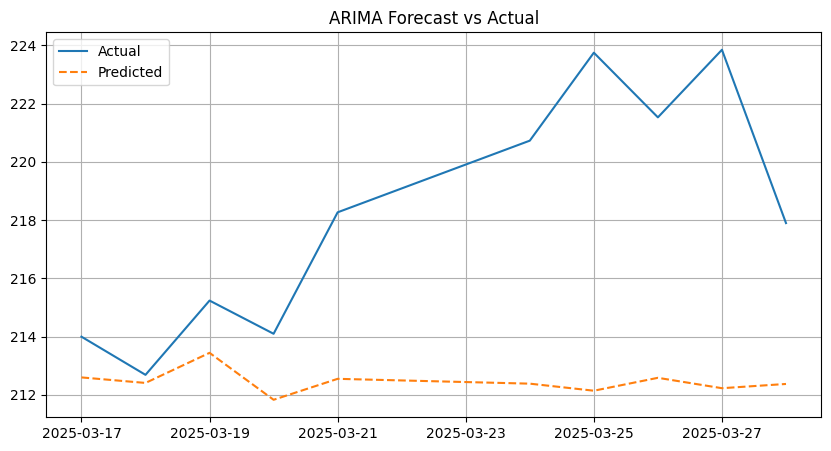

In [6]:
plt.figure(figsize=(10,5))
plt.plot(test_data, label='Actual')
plt.plot(predictions_series, label='Predicted', linestyle='--')
plt.title("ARIMA Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.show()

Starting ARIMA Baseline Evaluation...
Data loaded successfully. Shape: (3329, 14)
Total data points: 3329
Training split index: 2663 (Using first 80%)

--- Evaluating ARIMA (Manual Order) ---
Using ARIMA order: (1, 1, 1)
  Processed 100/666 steps...
  Processed 200/666 steps...
  Processed 300/666 steps...
  Processed 400/666 steps...
  Processed 500/666 steps...
  Processed 600/666 steps...
Walk-forward validation complete. Time elapsed: 0:01:40.910671
--- ARIMA Metrics ---
ARIMA_MAE: 2.1221
ARIMA_RMSE: 2.8853
ARIMA_MDA (%): 50.3759
ARIMA_Pearson: 0.9960
-------------------


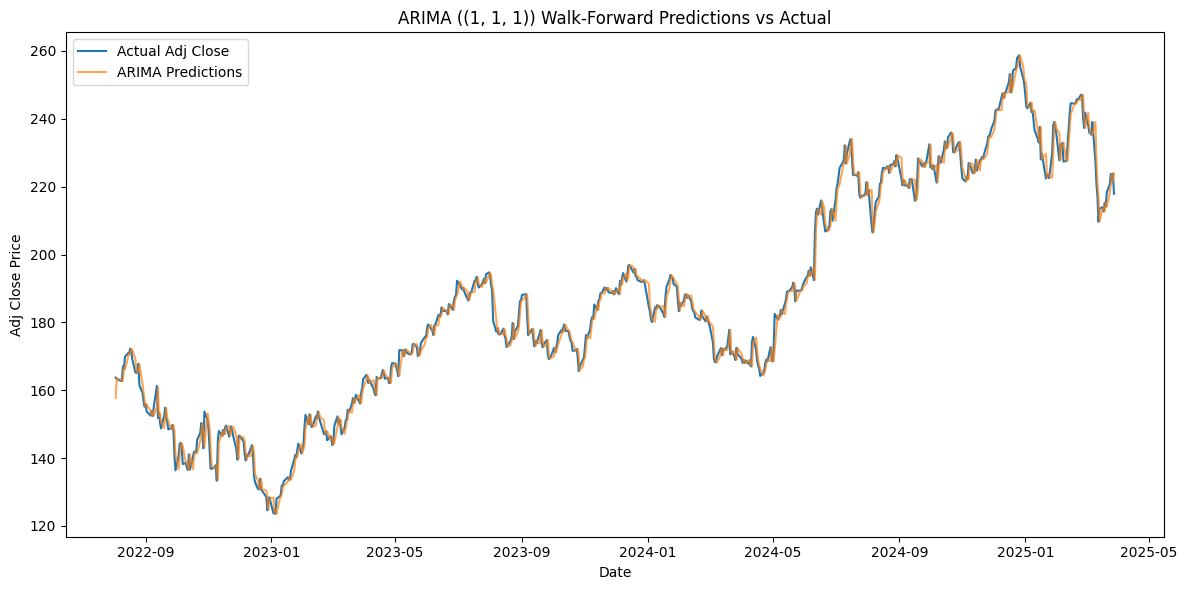

Saved ARIMA prediction plot to arima_predictions.png

ARIMA Parameters Used: (1, 1, 1)

--- Final ARIMA Metrics ---
   ARIMA_MAE  ARIMA_RMSE  ARIMA_MDA (%)  ARIMA_Pearson
0   2.122149     2.88526       50.37594       0.996029

ARIMA evaluation complete. Metrics saved to arima_baseline_metrics.csv


In [ ]:
import pandas as pd
import numpy as np
import os
import warnings
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# --- Configuration ---
FILE_PATH = '../../dataset/results0/AAPL_yahoo_data_0.csv'
TARGET_COLUMN = 'Adj Close'
TRAIN_SIZE_RATIO = 0.8
DEFAULT_ORDER = (1, 1, 1)  # <-- Set ARIMA order manually here

# --- Utility Functions ---

# --- Manual ARIMA Grid Search ---

# def grid_search_arima(train_data, p_range, d_range, q_range):
#     print("Starting manual grid search for ARIMA order...")
#     best_aic = np.inf
#     best_order = None
#     for p in p_range:
#         for d in d_range:
#             for q in q_range:
#                 try:
#                     model = ARIMA(train_data, order=(p, d, q))
#                     model_fit = model.fit()
#                     aic = model_fit.aic
#                     print(f"Evaluated ARIMA({p},{d},{q}) AIC: {aic:.2f}")
#                     if aic < best_aic:
#                         best_aic = aic
#                         best_order = (p, d, q)
#                 except Exception:
#                     continue
#     print(f"Best ARIMA order: {best_order} with AIC: {best_aic:.2f}")
#     return best_order if best_order else (1, 1, 1)

def load_data(filepath):
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Data file not found at {filepath}")
    try:
        df = pd.read_csv(filepath, index_col='Date', parse_dates=True)
        # if df.index.tz is not None:
        #     print("Converting index to timezone naive (UTC representation)")
        #     df.index = df.index.tz_convert(None)
        df.ffill(inplace=True)
        if TARGET_COLUMN not in df.columns:
            raise ValueError(f"Target column '{TARGET_COLUMN}' not found.")
        df[TARGET_COLUMN] = pd.to_numeric(df[TARGET_COLUMN], errors='coerce')
        df.dropna(subset=[TARGET_COLUMN], inplace=True)
        print(f"Data loaded successfully. Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def calculate_mda(y_true, y_pred):
    if len(y_true) != len(y_pred) or len(y_true) < 2:
        return np.nan
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = (np.sign(y_true_diff) == np.sign(y_pred_diff))
    return np.mean(correct_direction) * 100

def calculate_metrics(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mda = calculate_mda(y_true, y_pred)
    pearson = np.corrcoef(y_true, y_pred)[0, 1] if len(y_true) > 1 else np.nan
    metrics = {
        f'{model_name}_MAE': mae, f'{model_name}_RMSE': rmse,
        f'{model_name}_MDA (%)': mda, f'{model_name}_Pearson': pearson,
    }
    print(f"--- {model_name} Metrics ---")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    print("-" * (len(model_name) + 14))
    return metrics

# --- ARIMA Model with Manual Order ---

def evaluate_arima_manual(series, train_size, arima_order=DEFAULT_ORDER):
    print("\n--- Evaluating ARIMA (Manual Order) ---")
    train_data, test_data = series[:train_size], series[train_size:]
    history = list(train_data)
    predictions = []

    print(f"Using ARIMA order: {arima_order}")
    start_eval_time = datetime.now()
    for t in range(len(test_data)):
        try:
            model = ARIMA(history, order=arima_order)
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            predictions.append(yhat)
            history.append(test_data.iloc[t])
        except Exception as e:
            print(f"Warning: ARIMA fit/forecast failed at step {t+1}/{len(test_data)}. Error: {e}. Appending NaN.")
            predictions.append(np.nan)
            history.append(test_data.iloc[t])

        if (t + 1) % 100 == 0:
            print(f"  Processed {t+1}/{len(test_data)} steps...")

    print(f"Walk-forward validation complete. Time elapsed: {datetime.now() - start_eval_time}")

    predictions_array = np.array(predictions)
    valid_indices = ~np.isnan(predictions_array)
    if not np.any(valid_indices):
        print("ARIMA failed to produce any valid predictions.")
        return None, arima_order

    y_true_valid = test_data.iloc[valid_indices]
    y_pred_valid = predictions_array[valid_indices]

    metrics = calculate_metrics(y_true_valid, y_pred_valid, "ARIMA")

    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index, test_data.values, label='Actual Adj Close')
    plt.plot(test_data.index[valid_indices], y_pred_valid, label='ARIMA Predictions', alpha=0.7)
    plt.title(f'ARIMA ({arima_order}) Walk-Forward Predictions vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Adj Close Price')
    plt.legend()
    plt.tight_layout()
    # plt.savefig('arima_predictions.png')
    # plt.close()
    plt.show()
    print("Saved ARIMA prediction plot to arima_predictions.png")

    return metrics, arima_order

# --- Main Execution ---
if __name__ == "__main__":
    print("Starting ARIMA Baseline Evaluation...")
    df_full = load_data(FILE_PATH)
    target_series = df_full[TARGET_COLUMN]

    n = len(target_series)
    train_split_index = int(n * TRAIN_SIZE_RATIO)
    print(f"Total data points: {n}")
    print(f"Training split index: {train_split_index} (Using first {TRAIN_SIZE_RATIO*100:.0f}%)")

    all_metrics = {}
    try:
        arima_metrics, arima_order = evaluate_arima_manual(target_series, train_split_index)
        if arima_metrics:
            all_metrics.update(arima_metrics)
            print(f"\nARIMA Parameters Used: {arima_order}")
            metrics_df = pd.DataFrame([all_metrics])
            print("\n--- Final ARIMA Metrics ---")
            print(metrics_df.to_string())
            metrics_df.to_csv('arima_baseline_metrics.csv', index=False)
            print("\nARIMA evaluation complete. Metrics saved to arima_baseline_metrics.csv")
        else:
            print("\nARIMA evaluation failed.")

    except Exception as e:
        print(f"\nAn error occurred during the ARIMA process: {e}")


In [3]:
from mpl_toolkits.mplot3d import Axes3D

def grid_search_arima(train_data, p_range, d_range, q_range):
    print("Starting manual grid search for ARIMA order...")
    best_aic = np.inf
    best_order = None
    aic_scores = []

    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    model = ARIMA(train_data, order=(p, d, q))
                    model_fit = model.fit()
                    aic = model_fit.aic
                    aic_scores.append((p, d, q, aic))
                    print(f"Evaluated ARIMA({p},{d},{q}) AIC: {aic:.2f}")
                    if aic < best_aic:
                        best_aic = aic
                        best_order = (p, d, q)
                except Exception as e:
                    print(f"Skipped ARIMA({p},{d},{q}) due to error: {e}")

    # --- Plotting the AIC surface ---
    print("Plotting grid search AIC surface...")
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    ps, ds, qs, aics = zip(*aic_scores)
    sc = ax.scatter(ps, ds, qs, c=aics, cmap='viridis', s=80)
    ax.set_xlabel('p')
    ax.set_ylabel('d')
    ax.set_zlabel('q')
    ax.set_title('ARIMA Grid Search AIC Scores')
    fig.colorbar(sc, ax=ax, label='AIC')

    # Highlight best (p,d,q)
    best_idx = np.argmin(aics)
    ax.scatter([ps[best_idx]], [ds[best_idx]], [qs[best_idx]],
               color='red', s=120, marker='X', label='Best AIC')
    ax.legend()
    plt.tight_layout()
    plt.savefig('arima_gridsearch_aic_plot.png')
    plt.close()
    print("Saved ARIMA grid search plot to arima_gridsearch_aic_plot.png")

    return best_order if best_order else (1, 1, 1)


Starting ARIMA Baseline Evaluation...
Data loaded successfully. Shape: (3329, 14)
Total data points: 3329
Training split index: 2663 (Using first 80%)

--- Evaluating ARIMA (Manual Order) ---
Using ARIMA order: (1, 1, 1)
  Processed 100/666 steps...
  Processed 200/666 steps...
  Processed 300/666 steps...
  Processed 400/666 steps...
  Processed 500/666 steps...
  Processed 600/666 steps...
Walk-forward validation complete. Time elapsed: 0:01:41.183371
--- ARIMA Metrics ---
ARIMA_MAE: 2.1221
ARIMA_RMSE: 2.8853
ARIMA_MDA (%): 50.3759
ARIMA_Pearson: 0.9960
-------------------


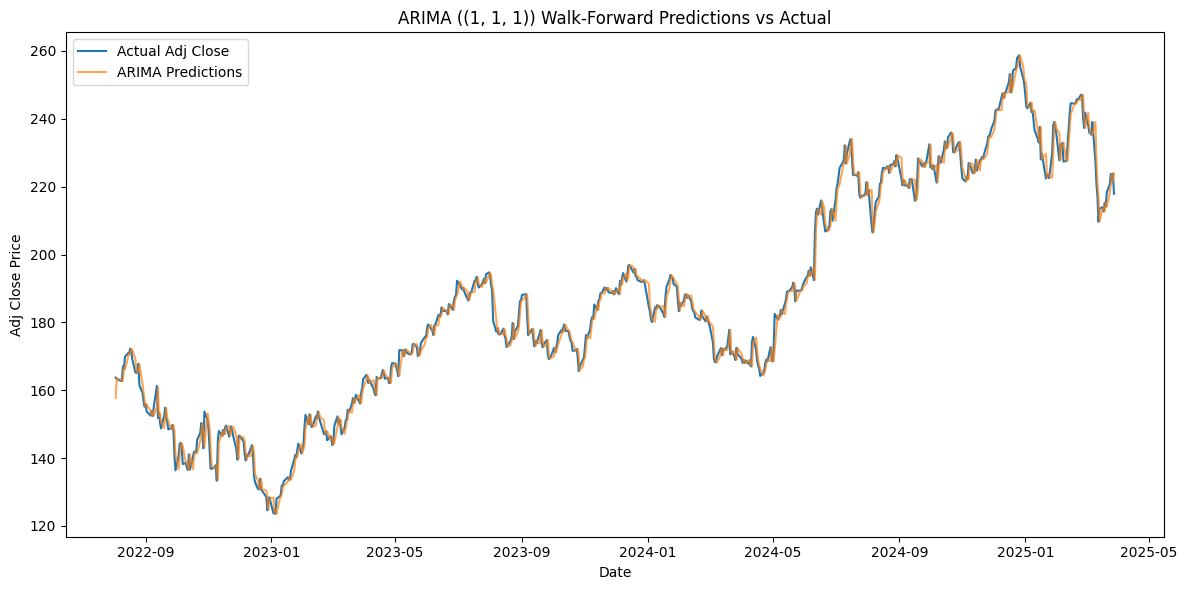

Saved ARIMA prediction plot to arima_predictions.png

ARIMA Parameters Used: (1, 1, 1)

--- Final ARIMA Metrics ---
   ARIMA_MAE  ARIMA_RMSE  ARIMA_MDA (%)  ARIMA_Pearson
0   2.122149     2.88526       50.37594       0.996029

ARIMA evaluation complete. Metrics saved to arima_baseline_metrics.csv


In [4]:
# --- Main Execution ---
if __name__ == "__main__":
    print("Starting ARIMA Baseline Evaluation...")
    df_full = load_data(FILE_PATH)
    target_series = df_full[TARGET_COLUMN]

    n = len(target_series)
    train_split_index = int(n * TRAIN_SIZE_RATIO)
    print(f"Total data points: {n}")
    print(f"Training split index: {train_split_index} (Using first {TRAIN_SIZE_RATIO*100:.0f}%)")

    all_metrics = {}
    try:
        arima_metrics, arima_order = evaluate_arima_manual(target_series, train_split_index)
        if arima_metrics:
            all_metrics.update(arima_metrics)
            print(f"\nARIMA Parameters Used: {arima_order}")
            metrics_df = pd.DataFrame([all_metrics])
            print("\n--- Final ARIMA Metrics ---")
            print(metrics_df.to_string())
            metrics_df.to_csv('arima_baseline_metrics.csv', index=False)
            print("\nARIMA evaluation complete. Metrics saved to arima_baseline_metrics.csv")
        else:
            print("\nARIMA evaluation failed.")

    except Exception as e:
        print(f"\nAn error occurred during the ARIMA process: {e}")

Starting ARIMA Baseline Evaluation...
Data loaded successfully. Shape: (3329, 14)
Total data points: 3329
Training split index: 2663 (Using first 80%)

--- Evaluating ARIMA with Manual Grid Search ---
Starting manual grid search for ARIMA order...
Evaluated ARIMA(0,0,0) AIC: 27860.98
Evaluated ARIMA(0,0,1) AIC: 24285.59
Evaluated ARIMA(0,0,2) AIC: 21298.64
Evaluated ARIMA(0,1,0) AIC: 9208.62
Evaluated ARIMA(0,1,1) AIC: 9202.02
Evaluated ARIMA(0,1,2) AIC: 9203.79
Evaluated ARIMA(1,0,0) AIC: 9223.84
Evaluated ARIMA(1,0,1) AIC: 9217.29
Evaluated ARIMA(1,0,2) AIC: 9219.07
Evaluated ARIMA(1,1,0) AIC: 9202.19
Evaluated ARIMA(1,1,1) AIC: 9203.54
Evaluated ARIMA(1,1,2) AIC: 9205.53
Evaluated ARIMA(2,0,0) AIC: 9217.45
Evaluated ARIMA(2,0,1) AIC: 9226.59
Evaluated ARIMA(2,0,2) AIC: 9216.39
Evaluated ARIMA(2,1,0) AIC: 9203.95
Evaluated ARIMA(2,1,1) AIC: 9205.52
Evaluated ARIMA(2,1,2) AIC: 9206.78
Plotting grid search AIC surface...


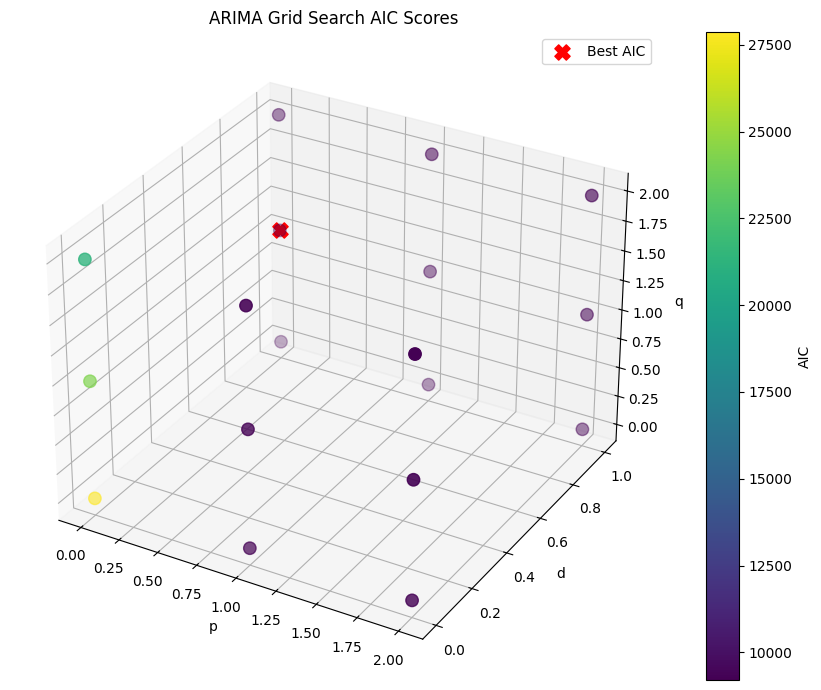

Saved ARIMA grid search plot to arima_gridsearch_aic_plot.png
Starting walk-forward validation with ARIMA order (0, 1, 1)...
  Processed 100/666 steps...
  Processed 200/666 steps...
  Processed 300/666 steps...
  Processed 400/666 steps...
  Processed 500/666 steps...
  Processed 600/666 steps...
Walk-forward validation complete. Time elapsed: 0:00:27.467805
--- ARIMA Metrics ---
ARIMA_MAE: 2.1218
ARIMA_RMSE: 2.8852
ARIMA_MDA (%): 50.3759
ARIMA_Pearson: 0.9960
-------------------
Saved ARIMA prediction plot to arima_predictions.png

ARIMA Best Parameters (Order): (0, 1, 1)

--- Final ARIMA Metrics ---
   ARIMA_MAE  ARIMA_RMSE  ARIMA_MDA (%)  ARIMA_Pearson
0   2.121756    2.885245       50.37594       0.996029

ARIMA evaluation complete. Metrics saved to arima_baseline_metrics.csv


In [6]:
import pandas as pd
import numpy as np
import os
import warnings
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# --- Configuration ---
FILE_PATH = '../../dataset/results0/AAPL_yahoo_data_0.csv'
TARGET_COLUMN = 'Adj Close'
TRAIN_SIZE_RATIO = 0.8
P_RANGE = range(0, 3)  # Try p = 0, 1, 2
D_RANGE = range(0, 2)  # Try d = 0, 1
Q_RANGE = range(0, 3)  # Try q = 0, 1, 2

# --- Utility Functions ---

def load_data(filepath):
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Data file not found at {filepath}")
    try:
        df = pd.read_csv(filepath, index_col='Date', parse_dates=True)
        # if df.index.tz is not None:
        #     print("Converting index to timezone naive (UTC representation)")
        #     df.index = df.index.tz_convert(None)
        df.ffill(inplace=True)
        if TARGET_COLUMN not in df.columns:
            raise ValueError(f"Target column '{TARGET_COLUMN}' not found.")
        df[TARGET_COLUMN] = pd.to_numeric(df[TARGET_COLUMN], errors='coerce')
        df.dropna(subset=[TARGET_COLUMN], inplace=True)
        print(f"Data loaded successfully. Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def calculate_mda(y_true, y_pred):
    if len(y_true) != len(y_pred) or len(y_true) < 2:
        return np.nan
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = (np.sign(y_true_diff) == np.sign(y_pred_diff))
    return np.mean(correct_direction) * 100

def calculate_metrics(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mda = calculate_mda(y_true, y_pred)
    pearson = np.corrcoef(y_true, y_pred)[0, 1] if len(y_true) > 1 else np.nan
    metrics = {
        f'{model_name}_MAE': mae, f'{model_name}_RMSE': rmse,
        f'{model_name}_MDA (%)': mda, f'{model_name}_Pearson': pearson,
    }
    print(f"--- {model_name} Metrics ---")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    print("-" * (len(model_name) + 14))
    return metrics

# --- Manual ARIMA Grid Search ---

def grid_search_arima(train_data, p_range, d_range, q_range):
    print("Starting manual grid search for ARIMA order...")
    best_aic = np.inf
    best_order = None
    aic_scores = []

    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    model = ARIMA(train_data, order=(p, d, q))
                    model_fit = model.fit()
                    aic = model_fit.aic
                    aic_scores.append((p, d, q, aic))
                    print(f"Evaluated ARIMA({p},{d},{q}) AIC: {aic:.2f}")
                    if aic < best_aic:
                        best_aic = aic
                        best_order = (p, d, q)
                except Exception as e:
                    print(f"Skipped ARIMA({p},{d},{q}) due to error: {e}")

    # --- Plotting the AIC surface ---
    print("Plotting grid search AIC surface...")
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    ps, ds, qs, aics = zip(*aic_scores)
    sc = ax.scatter(ps, ds, qs, c=aics, cmap='viridis', s=80)
    ax.set_xlabel('p')
    ax.set_ylabel('d')
    ax.set_zlabel('q')
    ax.set_title('ARIMA Grid Search AIC Scores')
    fig.colorbar(sc, ax=ax, label='AIC')

    # Highlight best (p,d,q)
    best_idx = np.argmin(aics)
    ax.scatter([ps[best_idx]], [ds[best_idx]], [qs[best_idx]],
               color='red', s=120, marker='X', label='Best AIC')
    ax.legend()
    plt.tight_layout()
    plt.savefig('arima_gridsearch_aic_plot.png')
    plt.show()
    plt.close()
    print("Saved ARIMA grid search plot to arima_gridsearch_aic_plot.png")

    return best_order if best_order else (1, 1, 1)

# --- ARIMA Evaluation ---

def evaluate_arima(series, train_size, p_range, d_range, q_range):
    print("\n--- Evaluating ARIMA with Manual Grid Search ---")
    train_data, test_data = series[:train_size], series[train_size:]
    history = list(train_data)
    predictions = []

    best_order = grid_search_arima(train_data, p_range, d_range, q_range)

    print(f"Starting walk-forward validation with ARIMA order {best_order}...")
    start_eval_time = datetime.now()
    for t in range(len(test_data)):
        try:
            model = ARIMA(history, order=best_order)
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            predictions.append(yhat)
            history.append(test_data.iloc[t])
        except Exception as e:
            print(f"Warning: ARIMA fit/forecast failed at step {t+1}/{len(test_data)}. Error: {e}. Appending NaN.")
            predictions.append(np.nan)
            history.append(test_data.iloc[t])

        if (t + 1) % 100 == 0:
            print(f"  Processed {t+1}/{len(test_data)} steps...")

    print(f"Walk-forward validation complete. Time elapsed: {datetime.now() - start_eval_time}")

    predictions_array = np.array(predictions)
    valid_indices = ~np.isnan(predictions_array)
    if not np.any(valid_indices):
        print("ARIMA failed to produce any valid predictions.")
        return None, best_order

    y_true_valid = test_data.iloc[valid_indices]
    y_pred_valid = predictions_array[valid_indices]

    metrics = calculate_metrics(y_true_valid, y_pred_valid, "ARIMA")

    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index, test_data.values, label='Actual Adj Close')
    plt.plot(test_data.index[valid_indices], y_pred_valid, label='ARIMA Predictions', alpha=0.7)
    plt.title(f'ARIMA ({best_order}) Walk-Forward Predictions vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Adj Close Price')
    plt.legend()
    plt.tight_layout()
    plt.savefig('arima_predictions.png')
    plt.close()
    print("Saved ARIMA prediction plot to arima_predictions.png")

    return metrics, best_order

# --- Main Execution ---
if __name__ == "__main__":
    print("Starting ARIMA Baseline Evaluation...")
    df_full = load_data(FILE_PATH)
    target_series = df_full[TARGET_COLUMN]

    n = len(target_series)
    train_split_index = int(n * TRAIN_SIZE_RATIO)
    print(f"Total data points: {n}")
    print(f"Training split index: {train_split_index} (Using first {TRAIN_SIZE_RATIO*100:.0f}%)")

    all_metrics = {}
    try:
        arima_metrics, arima_order = evaluate_arima(
            target_series, train_split_index, P_RANGE, D_RANGE, Q_RANGE
        )
        if arima_metrics:
            all_metrics.update(arima_metrics)
            print(f"\nARIMA Best Parameters (Order): {arima_order}")
            metrics_df = pd.DataFrame([all_metrics])
            print("\n--- Final ARIMA Metrics ---")
            print(metrics_df.to_string())
            metrics_df.to_csv('arima_baseline_metrics.csv', index=False)
            print("\nARIMA evaluation complete. Metrics saved to arima_baseline_metrics.csv")
        else:
            print("\nARIMA evaluation failed.")

    except Exception as e:
        print(f"\nAn error occurred during the ARIMA process: {e}")
